Load and Preprocess the Data

In [10]:
import os
import string
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import random
from sklearn.model_selection import train_test_split



# Define path to data
data_dir = 'enron1'

# Define categories
categories = ['ham', 'spam']
num_categories = len(categories)

# Define dataset class
class EmailDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

# Initialize variables
categories_to_emails = {'ham':[], 'spam':[]}


# Load data
for category in categories:
    # Get list of files
    path = os.path.join(data_dir, category)
    files = os.listdir(path)
    
    for file in files:
        # Read file
        with open(os.path.join(path, file), 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read()
            
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # add to dictionary
        categories_to_emails[category].append(text)


# Find the minimum length of the email lists in each category
min_len = min(len(email_list) for email_list in categories_to_emails.values())



# Create a new dictionary to store the randomly sampled emails
sampled_categories_to_emails = {'ham':[], 'spam':[]}

# Loop through the categories and the corresponding indices, and add the sampled emails to the new dictionary
for (category, email_list) in categories_to_emails.items():
    sample_indices = random.sample(range(len(email_list)), min_len)
    sampled_emails = [email_list[i] for i in sample_indices]
    sampled_categories_to_emails[category] = sampled_emails

emails = sampled_categories_to_emails['ham'] + sampled_categories_to_emails['spam']

# Create a list of corresponding labels (0 for ham, 1 for spam)
labels = ['ham'] * len(sampled_categories_to_emails['ham']) + ['spam'] * len(sampled_categories_to_emails['spam'])

# Shuffle the emails and labels in unison
shuffled_indices = list(range(len(emails)))
random.shuffle(shuffled_indices)
emails = [emails[i] for i in shuffled_indices]
labels = [labels[i] for i in shuffled_indices]
print("First 3 emails:")
for i in range(3):
    print("--------------------------------------Email:", emails[i])
    print("Label:", labels[i])



# Tokenize text
word_to_idx = {}
idx_to_word = {}
for email in emails:
    for word in email.split():
        if word not in word_to_idx:
            idx = len(word_to_idx)
            word_to_idx[word] = idx
            idx_to_word[idx] = word
vocab_size = len(word_to_idx)


# Convert text to sequence of indices
sequences = []
for email in emails:
    sequence = [word_to_idx[word] for word in email.split()]
    sequences.append(sequence)

# Pad sequences to be of equal length
max_len = max([len(seq) for seq in sequences])
padded_sequences = []
for seq in sequences:
    seq = torch.LongTensor(seq)
    padded_seq = torch.zeros(max_len, dtype=torch.long)
    padded_seq[:len(seq)] = seq
    padded_sequences.append(padded_seq)
    
# Convert labels to categorical
cat_labels = torch.tensor([categories.index(label) for label in labels], dtype=torch.long)




print("Vocab_Size:", vocab_size, "NumSpam:", len(sampled_categories_to_emails['spam']), "NumHam:", len(sampled_categories_to_emails['ham']) , "MaxSequenceLen:", max_len)
print(padded_sequences[1000], cat_labels[1000])


First 3 emails:
--------------------------------------Email: Subject neon discussion february 14
hey guys and girls   i  ve attached an outline that brad used at saturn
road    you might want to use    it kind of dovetails with the evangelism
focus that shon  s incorporating into his sermons and the connection group
topics   and since it  s valentine  s day this wednesday  you might want to
use wednesday night for something light to shake things up   as always  it  s
your call 

bobby
 naaman  doc
Label: ham
--------------------------------------Email: Subject shell cogen changes
fyi
the shell cogen ticket is at 105  000 dth for nov  same day for the first 
shell took 5 m off of 1581 and added 5 m to 1060 
please give me a call if you have any questions 
mary
Label: ham
--------------------------------------Email: Subject txu nom  s for wed  9  6  00
ok  so you couldn  t guess what the noms  were so i  ll attach the answer 
 see attached file  hplo 906  xls 
 hplo 906  xls
Label: ham
V

Define data loaders

In [36]:
train_percent = .6
test_percent = .2
validation_percent = .2

# Split data into train, test, and validation sets
train_data, test_val_data, train_labels, test_val_labels = train_test_split(padded_sequences, cat_labels, test_size=test_percent+validation_percent, stratify=cat_labels)
val_data, test_data, val_labels, test_labels = train_test_split(test_val_data, test_val_labels, test_size=test_percent/(test_percent+validation_percent), stratify=test_val_labels)


train_dataset = EmailDataset(train_data, train_labels)
test_dataset = EmailDataset(test_data, test_labels)
validation_dataset = EmailDataset(val_data, val_labels)


# Define data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
print("Train Size:", len(train_dataset), "Test Size:", len(test_dataset), "Validation Size:", len(validation_dataset))

Train Size: 1800 Test Size: 600 Validation Size: 600


Define Model

In [37]:
import torch.nn.functional as F
class WordLSTM(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size, batch_size):
        super(WordLSTM, self).__init__()
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = nn.Sigmoid()
    
    
    def forward(self, x, h):
        
        x = self.embedding(x)
        # shape is batch_size, seq_len, 
        out, hn = self.lstm(x, h)
        # only pass in last out
        out = self.fc(out[:, -1])
        out = self.activation(out)
        return torch.squeeze(out, dim=1), hn
        

Initialize Cuda if available

In [38]:
if torch.cuda.is_available():
    print("CUDA is available!")
    device = torch.device("cuda")
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")
    print(torch.__version__)
    device = torch.device("cpu")

CUDA is available!
GPU: NVIDIA GeForce GTX 1080 Ti


Initialize Model

In [39]:
# Define hyperparameters
hidden_size = 15
embedding_size = 100
num_layers = 2

# Initialize model, loss function, and optimizer
model = WordLSTM(vocab_size, embedding_size, hidden_size, num_layers, 1, batch_size)
model.to(device)
print(model)
print(sum(p.numel() for p in model.parameters()))


WordLSTM(
  (embedding): Embedding(46519, 100)
  (lstm): LSTM(100, 15, num_layers=2, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
  (activation): Sigmoid()
)
4660856


Initialize Model and Criterion

In [40]:
import torch.optim as optim

learning_rate = 0.03


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 2)

Train Model

In [43]:
def init_hidden(num_layers, num_inputs, hidden_size, device):
    return (torch.zeros(num_layers, num_inputs, hidden_size).to(device), torch.zeros(num_layers, num_inputs, hidden_size).to(device))
    
num_epochs = 100
clip = 5
# Train the model
train_loss_arr = []
val_loss_arr = []
for epoch in range(num_epochs):
    #scheduler.step(epoch)
    train_loss = 0
    
    # Train the model on the training set
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        h = init_hidden(num_layers, inputs.size(0), hidden_size, device)

        # Zero the gradients

        # Forward pass
        outputs, hn = model(inputs, h)
        
        
        loss = criterion(outputs.float(), labels.float())
        train_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)  # clip the norm of the gradients
        optimizer.step()
        
        #if(i%10==0): 
            #print(i, "out of", len(train_loader), "batches trained. Average loss so far:", train_loss/(i+1))
    print(outputs)
        
    train_loss /= len(train_loader)
    train_loss_arr.append(train_loss)
    
    
    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for i, (inputs, labels) in enumerate(validation_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            h = init_hidden(num_layers, inputs.size(0), hidden_size, device)
            outputs, hn = model(inputs, h)
            loss = criterion(outputs.float(), labels.float())
            val_loss += loss.item()

        val_loss /= len(validation_loader)
        val_loss_arr.append(val_loss)
        
    # Print the average train and validation losses for this epoch
    print("Epoch {}/{} Train Loss: {:.4f} Validation Loss: {:.4f}".format(epoch+1, num_epochs, train_loss, val_loss))

tensor([0.4988, 0.4988, 0.4988, 0.4988, 0.4988, 0.4988, 0.4988, 0.4988],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Epoch 1/100 Train Loss: 0.6931 Validation Loss: 0.6931
tensor([0.4952, 0.4952, 0.4952, 0.4952, 0.4952, 0.4952, 0.4952, 0.4952],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Epoch 2/100 Train Loss: 0.6931 Validation Loss: 0.6932
tensor([0.4996, 0.4996, 0.4996, 0.4996, 0.4996, 0.4996, 0.4996, 0.4996],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Epoch 3/100 Train Loss: 0.6931 Validation Loss: 0.6931
tensor([0.4808, 0.4808, 0.4808, 0.4808, 0.4808, 0.4808, 0.4808, 0.4808],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Epoch 4/100 Train Loss: 0.6945 Validation Loss: 0.6935
tensor([0.5154, 0.5154, 0.5154, 0.5154, 0.5154, 0.5154, 0.5154, 0.5154],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Epoch 5/100 Train Loss: 0.6943 Validation Loss: 0.6936
tensor([0.5015, 0.5015, 0.5015, 0.5015, 0.5015, 0.5015, 0.5015, 0.5015],
       device='cuda:0', gra

Evaluate Model

tensor([0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961,
        0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961,
        0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961,
        0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961,
        0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961,
        0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961,
        0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961,
        0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961,
        0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961,
        0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961,
        0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961,
        0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961, 0.4961,
        0.4961, 0.4961, 0.4961, 0.4961, 

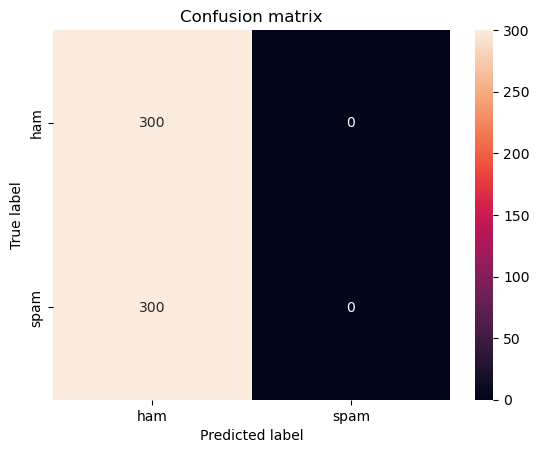

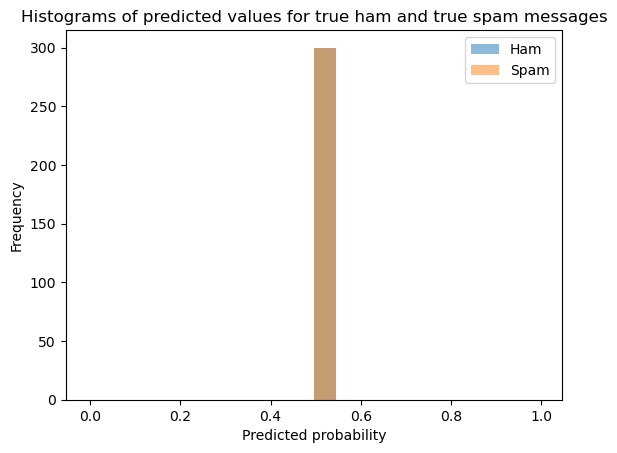

Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
ROC-AUC score: 0.5000


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def print_model_results(model):
    model.eval()
    preds = []
    targets = []
    raw_outputs = []
    ham_preds = []
    spam_preds = []
    num_printed = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            h = init_hidden(num_layers, inputs.size(0), hidden_size, device)

            # Forward pass
            outputs, h = model(inputs, h)
            if(num_printed<2): 
                print(outputs)
                num_printed+=1
            raw_outputs.append(outputs.cpu())
            preds.append((outputs>.5).cpu().long().numpy())
            targets.append(labels.cpu().numpy())
            for i, label in enumerate(labels):
                if label == 0:
                    ham_preds.append(outputs[i].cpu().numpy())
                else:
                    spam_preds.append(outputs[i].cpu().numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    raw_outputs = np.concatenate(raw_outputs)


    cm = confusion_matrix(targets, preds)

    # Create heatmap with labeled rows and columns
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories)

    # Add axis labels and title
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')

    # Show the plot
    plt.show()
    


     # show the plot

    # Create histograms of predicted values for true ham and true spam messages
    plt.hist(ham_preds, bins=20, alpha=0.5, label='Ham')
    plt.hist(spam_preds, bins=20, alpha=0.5, label='Spam')
    plt.legend(loc='upper right')
    plt.xlabel('Predicted probability')
    plt.ylabel('Frequency')
    plt.title('Histograms of predicted values for true ham and true spam messages')
    plt.show()


    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, zero_division=0)
    rec = recall_score(targets, preds)
    f1 = f1_score(targets, preds)
    roc_auc = roc_auc_score(targets, raw_outputs)
    print("Accuracy: {:.4f}".format(acc))
    print("Precision: {:.4f}".format(prec))
    print("Recall: {:.4f}".format(rec))
    print("F1-score: {:.4f}".format(f1))
    print("ROC-AUC score: {:.4f}".format(roc_auc))


print_model_results(model)